# Applied ML

##### Table of Contents
[Exercise 1](#Exercise 1)  
- Data pre-processing
- Initial cleaning
- Making the class feature
- Feature transformation
- Feature combinations
- Aggregating over the players
- Standardizing of data set
- Machine Learning by RandomForestClassifier
- Performance assessment 
- Statistical significance of result
- Bonus: Learning curve

[Exercise 2](#Exercise 2)  
- Aggregate the referee information grouping by soccer player
  

In [68]:
# Normal stack of pandas, numpy, matplotlib and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Statistical test library
import scipy.stats as stats
import random

from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, make_scorer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline

np.random.seed(10)
random.seed(10)

# Exercise 1
<a name="Exercise 1"/>

## Data pre-processing

In [69]:
# Load the dataset
original = pd.read_csv("CrowdstormingDataJuly1st.csv", parse_dates=['birthday'], infer_datetime_format=True)

In [70]:
original.describe()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,145765.000000,143785.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,124621.000000,124621.000000,146028.000000,146028.000000,145865.000000,1.458650e+05,1.458650e+05,145865.000000,1.458650e+05,145865.000000
mean,181.935938,76.075662,2.921166,1.278344,0.708241,0.934581,0.338058,0.385364,0.011381,0.012559,0.264255,0.302862,1534.827444,29.642842,0.346276,1.969741e+04,6.310849e-04,0.452026,2.044023e+04,0.002994
std,6.738726,7.140906,3.413633,1.790725,1.116793,1.383059,0.906481,0.795333,0.107931,0.112889,0.295382,0.293020,918.736625,27.496189,0.032246,1.271262e+05,4.735857e-03,0.217469,1.306157e+05,0.019723
min,161.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,641.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1604.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,2345.000000,44.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,203.000000,100.000000,47.000000,29.000000,14.000000,18.000000,23.000000,14.000000,3.000000,2.000000,1.000000,1.000000,3147.000000,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


In [4]:
# First glimpse at data content
original.ix[:5,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,1982-01-08,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,1992-12-17,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,1993-08-31,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,1991-07-18,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,1979-11-08,182.0,71.0,Center Back,1,0,0,1,0


In [5]:
original.ix[:5,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Challenges in dataset:

- Skin ratings don't match -> take average
- Picture was missing -> exclude from training
- No cards drawn in some dyads


Prune dataset where there is no rater information

In [6]:
# Helper function to see the efect when we drop rows
def dropping_stats(df):
    drop_perc =  100 * (original.shape[0] - df.shape[0]) / original.shape[0]
    print("%.2f%% of original data droped." % (drop_perc) )
    
    print("Now: %d rows" % df.shape[0] )

# Initial cleaning


In [7]:
# Drop columns that will not be relevant for our model
original['year'] = original['birthday'].apply(lambda x: x.year)

#nan-dropping
data = original.dropna(how='any', subset=['rater1', 'rater2', 'meanExp', 'meanIAT']) \
    .drop(['photoID', 'refCountry', 'Alpha_3', 'player', 'birthday'], axis=1)

In [8]:
# If a referee is present in less than 22 triads (rows), he cannot have
# refereed a match in these leages.
ref_grouped = data[['refNum', 'games']].groupby(['refNum']).sum()
ref_filtered = ref_grouped[ref_grouped['games'] >= 22].reset_index()

# Therefore, we filter the data on this condition
has_referee = data[data['refNum'].isin(ref_filtered['refNum'].values)]
cleaned = has_referee
dropping_stats(cleaned)


20.21% of original data droped.
Now: 116522 rows


In [9]:
cleaned = cleaned[cleaned['meanIAT'].notnull()]

### Dealing with nan-values


In [10]:
cleaned['weight'].isnull().value_counts()

False    115874
True        648
Name: weight, dtype: int64

In [11]:
cleaned['height'].isnull().value_counts()

False    116499
True         23
Name: height, dtype: int64

In [12]:
cleaned['leagueCountry'].isnull().value_counts()

False    116522
Name: leagueCountry, dtype: int64

We will fill these with the mean value

In [13]:
cleaned['weight'].fillna(cleaned['weight'].mean(), inplace=True)
cleaned['height'].fillna(cleaned['height'].mean(), inplace=True)

In [14]:
print(cleaned['height'].hasnans)
print(cleaned['weight'].hasnans)

False
False


## Making the class feature

To make the class of the skin color of each player, we take the mean of the value from the two raters. 
Players that does not have a rating gets dropped.

In [15]:
def get_binary_class(x):
    """ Returns 0 for players rated below 0.5 ('light-skinned') and 1 for players rated above ('dark-skinned')"""
    if x <= 0.5:
        return 0
    else:
        return 1

In [16]:
# Take the mean of the two raters value
mean_rating = has_referee[['rater1', 'rater2']].mean(axis=1)

# Drop the players that does not have a rating
mean_rating.dropna(inplace=True)

dropping_stats(mean_rating)

20.21% of original data droped.
Now: 116522 rows


In [17]:
# The players now have a rating between 0 and 1, real numbers
mean_rating.head()

5    0.125
6    0.125
7    1.000
8    0.250
9    0.000
dtype: float64

In [18]:
# Since we want to do a binary classification, we convert the real numbers to 0/1

binary_class = mean_rating.apply(get_binary_class)
binary_class.name = 'class'
binary_class.head()

5    0
6    0
7    1
8    0
9    0
Name: class, dtype: int64

In [19]:
# Keep only the data rows where we have the class

has_class = has_referee.ix[binary_class.index]
dropping_stats(has_class)

20.21% of original data droped.
Now: 116522 rows


In [20]:
counts = binary_class.value_counts()
counts

0    98033
1    18489
Name: class, dtype: int64

In [21]:
print("%.2f%% of the examples are light skinned" % (counts[0] / (counts[0] + counts[1]) * 100))

84.13% of the examples are light skinned


## Feature transformation

When we have categorical data, we need to transform them so that they can be taken into account in our model. We du this by using Panda's dummy-encoder, which transforms a feature into many one hot encoded features.

In [22]:
countries_encoded = pd.get_dummies(has_class['leagueCountry'])
countries_encoded.head()

,England,France,Germany,Spain
5,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0


In [23]:
position_encoded = pd.get_dummies(has_class['position'])
position_encoded.head()

,Attacking Midfielder,Center Back,Center Forward,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


We remove the original categorical features, and attatch the new one_hot_encoded ones :

### Feature combinations

In [24]:
# Our hypothesis is that the combination of the referees 'discrimination score' and cards given,
# might help us classify the players. E.g., if a player got many cards from racist referees, 
# he is more likely dark-skinned.

red_exp = has_class['redCards'] * has_class['meanExp'] 
yellow_exp = has_class['yellowCards'] * has_class['meanExp']
yellow_red_exp = has_class['yellowReds'] * has_class['meanExp']

red_iat = has_class['redCards'] * has_class['meanIAT'] 
yellow_iat = has_class['yellowCards'] * has_class['meanIAT']
yellow_red_iat = has_class['yellowReds'] * has_class['meanIAT']

cards_iat = pd.concat([red_exp, yellow_exp, yellow_red_exp, red_iat, yellow_iat, yellow_red_iat], axis=1)
cards_iat.columns = ['red_exp', 'yellow_exp', 'red_yellow_exp', 'red_iat', 'yellow_iat', 'red_yellow_iat']
cards_iat.head(10)

,red_exp,yellow_exp,red_yellow_exp,red_iat,yellow_iat,red_yellow_iat
5,0.0,0.000000,0.0,0.0,0.000000,0.0
6,0.0,0.000000,0.0,0.0,0.000000,0.0
7,0.0,0.000000,0.0,0.0,0.000000,0.0
8,0.0,0.000000,0.0,0.0,0.000000,0.0
9,0.0,0.000000,0.0,0.0,0.000000,0.0
10,0.0,0.538462,0.0,0.0,0.325185,0.0
11,0.0,0.000000,0.0,0.0,0.000000,0.0
12,0.0,0.000000,0.0,0.0,0.000000,0.0
13,0.0,0.000000,0.0,0.0,0.000000,0.0
14,0.0,0.000000,0.0,0.0,0.000000,0.0


#### Combining the features

In [25]:
columns_from_orig = ['playerShort', 'year', 'height', 'weight', 'games', 'victories','ties', 'defeats','goals','yellowCards',
                     'yellowReds','redCards','meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']

colomns_one_hot_enoded = countries_encoded.columns | position_encoded.columns

features = has_class[columns_from_orig].join(countries_encoded).join(position_encoded).join(cards_iat).join(binary_class)
features.head()

,playerShort,year,height,weight,games,victories,ties,defeats,goals,yellowCards,...,Right Fullback,Right Midfielder,Right Winger,red_exp,yellow_exp,red_yellow_exp,red_iat,yellow_iat,red_yellow_iat,class
5,aaron-hughes,1979,182.0,71.0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,aleksandar-kolarov,1985,187.0,80.0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,alexander-tettey,1986,180.0,68.0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,anders-lindegaard,1984,193.0,80.0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,andreas-beck,1987,180.0,70.0,1,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Aggregating over the players:

We now run grouping and aggregation of our dataframe. The aggregation functions used are defined in two dictionarys.
Each element of the dictionarys contains of a column name and an aggregation function, which is applied to our grouped features.

In [27]:
players = features.groupby(['playerShort','year','height', 'weight'])

# We sum over the one hot encoded features
one_hot_aggregation = {i: max for i in colomns_one_hot_enoded}

# And then sum over games, victories, ties, defeats, goals, cards, 
column_aggfunc_mapping = {'class': max, 'games': sum, 'victories': sum, 'ties': sum, 'defeats': sum, 'goals': sum,
                          'yellowCards': sum, 'yellowReds': sum, 'redCards': sum, 'red_exp': sum,
                          'yellow_exp': sum, 'red_yellow_exp': sum, 'red_iat': sum,
                          'yellow_iat': sum, 'red_yellow_iat': sum, 'meanIAT': np.mean, 'meanExp': np.mean}

# Union the aggregation function dicts
agg_funcs = {**one_hot_aggregation, **column_aggfunc_mapping}

agg_features = players.agg(agg_funcs)
agg_features = agg_features.reset_index().set_index('playerShort')
agg_features.head()

,year,height,weight,yellow_exp,games,Right Midfielder,yellow_iat,goals,Right Fullback,Attacking Midfielder,...,meanIAT,red_yellow_iat,England,Spain,class,yellowCards,meanExp,Right Winger,red_iat,red_exp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,8.230927,646,0.0,6.420221,8,0.0,0.0,...,0.345236,0.000000,1.0,0.0,0,19,0.489953,0.0,0.000000,0.000000
aaron-hunt,1986,183.0,73.0,16.268793,335,0.0,14.374395,62,0.0,1.0,...,0.348943,0.000000,0.0,0.0,0,42,0.450376,0.0,0.336628,0.335967
aaron-lennon,1987,165.0,63.0,4.423886,412,1.0,3.651979,31,0.0,0.0,...,0.345893,0.000000,1.0,0.0,0,11,0.491482,0.0,0.000000,0.000000
aaron-ramsey,1990,178.0,76.0,13.311479,253,0.0,10.462342,39,0.0,0.0,...,0.347013,0.000000,1.0,0.0,0,31,0.511374,0.0,0.334684,0.336101
abdelhamid-el-kaoutari,1990,180.0,73.0,2.688808,124,0.0,2.677471,1,0.0,0.0,...,0.331600,1.356972,0.0,0.0,0,8,0.335587,0.0,0.669368,0.672202


## Standardizing of data set

In [28]:
from sklearn.preprocessing import scale

X = scale(agg_features, axis=1)
X

array([[ 5.53010876,  0.243798  , -0.08273538, ..., -0.29159908,
        -0.29159908, -0.29159908],
       [ 5.78927259,  0.29916028, -0.03578834, ..., -0.25807242,
        -0.25704739, -0.2570494 ],
       [ 5.74128325,  0.23891952, -0.06911621, ..., -0.25937357,
        -0.25937357, -0.25937357],
       ..., 
       [ 5.75397712,  0.28936717, -0.03297488, ..., -0.26408804,
        -0.25767163, -0.25577511],
       [ 5.88487356,  0.36657495,  0.05676496, ..., -0.20089878,
        -0.19862954, -0.19728967],
       [ 5.86616956,  0.3465294 ,  0.015351  , ..., -0.22383341,
        -0.22383341, -0.22383341]])

## Machine Learning by RandomForestClassifier

We now split our dataframe into X (examples) and y (classes)

In [29]:
X = agg_features.drop('class', axis=1)
y = agg_features['class']

### Baseline model

To know what kind of results we can expect, we make a baseline model:

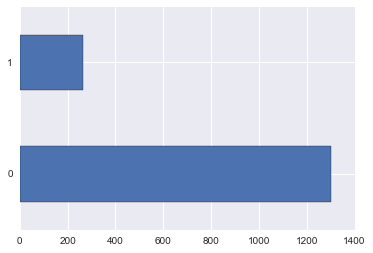

In [30]:
y.value_counts().plot(kind='barh', stacked=True)
plt.show()

In [74]:
print('There are about %.2f%% zeros in the class vector.' % (y.value_counts()[0] / y.shape[0]*100))

There are about 83.17% zeros in the class vector.


The result above shows that by allways predicting 0, we could achieve an accuracy of approximately 83%. 
We should therefore expect that our classifier performs at least as good as this, and hopefully significantly better. 

Let us try doing a k-fold cross validation with a dummy classifier that allways predicts the most frequent class:

In [32]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy_scores = cross_val_score(dummy, X, y, cv=10, n_jobs=-1)

print('Scores: %s\n\nAchieved model score: %.3f' % (dummy_scores, np.mean(dummy_scores)))

Scores: [ 0.82802548  0.82802548  0.82802548  0.83333333  0.83333333  0.83333333
  0.83333333  0.83333333  0.83333333  0.83333333]

Achieved model score: 0.832


As we can see, our dummy model achieves an accuracy score of 0.832 on average, which is what we expected.

### Random forest

To avoid over- and underfitting in our random forest model, we want to find the best hyperparameters for the random forest model. This tuning is done by defining a range for each of the parameters we want to tune, and then evaluating the score by running a grid-search over all the permutations. 

In [33]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10, random_state=42) 

param_grid = {
    'max_features': ['log2','sqrt', None],
    'min_samples_leaf': [2,10,20],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'max_depth': [4,8,16,None],
}

#### Optimizing for accuracy

In [34]:
CV_rfc = GridSearchCV(estimator=rfc, scoring='accuracy', param_grid=param_grid, cv=10, verbose=True, n_jobs=-2)
CV_rfc.fit(X, y, )
print(CV_rfc.best_params_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed:  1.1min


{'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None, 'max_depth': 16}


[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed:  1.4min finished


### Training the model

We use the results found in the grid search to tune our random forrest classifier.

In [35]:
rfc = RandomForestClassifier(n_estimators=500, \
                             max_features='log2', \
                             max_depth=16, \
                             random_state=4, \
                             n_jobs=-2)
print(rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-2, oob_score=False, random_state=4,
            verbose=0, warm_start=False)


## Inspect most relevant features of RandomForest

Feature ranking:
1. feature 31 : meanExp  (0.093726)
2. feature 26 : meanIAT  (0.088503)
3. feature 10 : victories  (0.058373)
4. feature 4 : games  (0.055299)
5. feature 7 : goals  (0.054625)
6. feature 3 : yellow_exp  (0.053669)
7. feature 6 : yellow_iat  (0.051908)
8. feature 13 : defeats  (0.051746)
9. feature 2 : weight  (0.049718)
10. feature 17 : ties  (0.047174)
11. feature 1 : height  (0.042067)
12. feature 30 : yellowCards  (0.042022)
13. feature 0 : year  (0.039875)
14. feature 16 : France  (0.033940)
15. feature 19 : red_yellow_exp  (0.027715)
16. feature 34 : red_exp  (0.027090)
17. feature 33 : red_iat  (0.025510)
18. feature 27 : red_yellow_iat  (0.023273)
19. feature 25 : Germany  (0.018798)
20. feature 15 : redCards  (0.014953)
21. feature 22 : yellowReds  (0.014133)
22. feature 18 : Center Forward  (0.012424)
23. feature 29 : Spain  (0.010393)
24. feature 28 : England  (0.009368)
25. feature 32 : Right Winger  (0.007109)
26. feature 24 : Defensive Midfielder  (0.00667

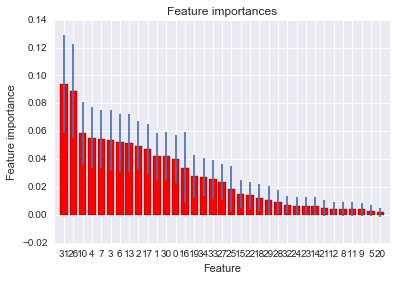

In [36]:
rfc.fit(X, y)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d : %s  (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.show()

## Performance assessment 

### Cross-validation

To see how our model performs, we run a k-fold cross validation, with k=10.

In [37]:
rfc_acc = cross_val_score(rfc, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print(rfc_acc)
print('Achieved model score: ', np.mean(rfc_acc))

[ 0.82165605  0.84076433  0.82802548  0.82051282  0.85897436  0.8525641
  0.83974359  0.84615385  0.8525641   0.82692308]
Achieved model score:  0.838788175731


In [38]:
# Use dummy classifier for reference
dummy_acc = cross_val_score(dummy, X, y, cv=10, scoring='accuracy', n_jobs=-1)

Visualize score results as boxplots

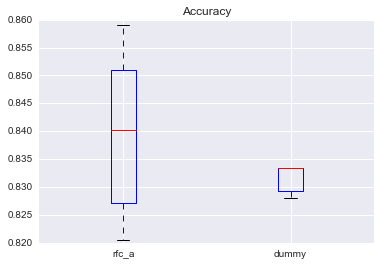

In [39]:
plt.title('Accuracy')
plt.boxplot([rfc_acc,dummy_acc], labels=['rfc_a', 'dummy'], )
plt.show()

As we can see, our model is only slightly better than the dummy classifier (on average)

### Confusion matrix

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1250, 35) (313, 35) (1250,) (313,)


In [41]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      0.98      0.93       274
          1       0.50      0.13      0.20        39

avg / total       0.84      0.88      0.84       313



Visualize confusion matrix

Confusion matrix, without normalization
[[1295    5]
 [  35  228]]


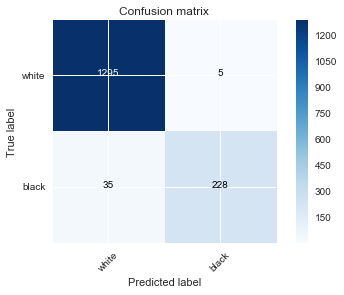

In [51]:
from plot_helpers import custom_confusion_matrix
from sklearn.metrics import confusion_matrix

y_true = y
y_pred = rfc.predict(X)

cm = confusion_matrix(y_true, y_pred)

custom_confusion_matrix(cm, classes=['white','black'], title='Confusion matrix')

## Statistical significance of result

Here we test the distribution of the achieved learning score against the learning score value achieved by a simple DummyClassifier to see if our model actually performs significantly better.

In [43]:
from scipy.stats import ttest_ind
print("Dummy classifier accuracy: ", np.mean(dummy_acc))
print("Random forest classifier accuracy: ", np.mean(rfc_acc))
t,p_value = ttest_ind(rfc_acc, dummy_acc, axis=0)
print("Achieved P-Value: ", p_value)

Dummy classifier accuracy:  0.831740976645
Random forest classifier accuracy:  0.838788175731
Achieved P-Value:  0.131411455992


Since the p-value is below 0.05 we do reject the null hypothesis which is the assumption that the mean of the random sample consisting of the results of our crossvalidation is equal to true mean, consisting of the dummy classifier ratio. This concludes that our models performance has statistically significantly improved over the random level class ratio.

# Bonus: Learning curve


In [44]:
#train_sizes = np.arange(300,1201, int((1201-300)/20))
train_sizes = np.arange(0.1, 1.0, 0.8/3)
train_sizes.shape

(4,)

In [45]:
train_sizes, train_scores, test_scores = learning_curve(
     rfc, X, y, train_sizes=train_sizes, cv=10, n_jobs=-1)

In [76]:
rfc2 = RandomForestClassifier(n_estimators=1000, \
                             max_features='log2', \
                             max_depth=8, \
                             random_state=4, \
                             n_jobs=-2)
print(rfc2)
rfc2.fit(X_train, y_train)

y_pred2 = rfc2.predict(X_test)
print(classification_report(y_test, y_pred2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-2, oob_score=False, random_state=4,
            verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       274
          1       0.62      0.13      0.21        39

avg / total       0.86      0.88      0.85       313



<module 'matplotlib.pyplot' from '/home/raccct/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

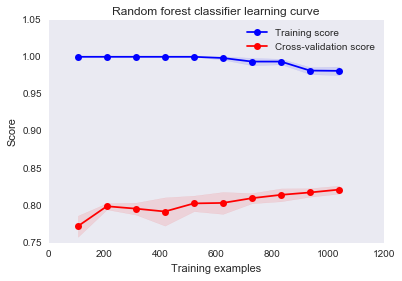

In [78]:
custom_learning_curve(rfc, 'RFC regular fitted learning curve', X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.show()

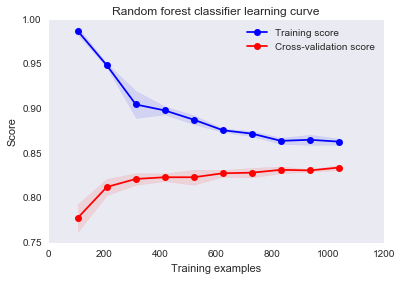

In [79]:
custom_learning_curve(rfc2, 'RFC underfitted learning curve', X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.show()

The learning curves of the above plots show us that the model based on GridSearch which is the former gives better results than the alternatively tested classifier RFC2 with maxdepth of 8 and an estimator count of 1000. 

# Exercise 2
<a name="Exercise 2"/>

For the aggregation the referee information grouping by soccer player we use original features only, since it was not specified in the homework description whether or not we should use our base features alongside engineered ones.

Moreover using base features for clustering is a little easier to comprehend and explain.

### Aggregate the referee information grouping by soccer player

In [55]:
#Group by soccer player
has_class2 = original.join(binary_class, how='right')
grouped_features = has_class2.groupby(['playerShort', 'birthday', 'height', 'weight'])
grouped_features.first()

#Aggregate referee information
column_aggfunc_mapping = {'class': max,'games': sum, 'victories': sum, 'ties': sum, \
                          'defeats': sum, 'goals': sum, 'yellowCards': sum, 'yellowReds': sum, \
                          'redCards': sum, 'meanIAT': np.mean, 'nIAT': np.mean, 'meanExp': np.mean, \
                          'nExp': np.mean}

aggregated_features = grouped_features.agg( column_aggfunc_mapping ) \
                            .reset_index() \
                            .set_index('playerShort')

#Convert birthday date column to seperate year, month and day columns
aggregated_features['year'] = aggregated_features['birthday'].dt.year
aggregated_features['month'] = aggregated_features['birthday'].dt.month
aggregated_features['day'] = aggregated_features['birthday'].dt.day

aggregated_features = aggregated_features.drop(['birthday'], axis=1)
aggregated_features.head()

,height,weight,goals,yellowReds,meanIAT,games,victories,ties,class,defeats,nIAT,redCards,yellowCards,meanExp,nExp,year,month,day
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,8,0,0.345236,646,243,179,0,224,20417.196203,0,19,0.489953,21377.443038,1979,11,8
aaron-hunt,183.0,73.0,62,0,0.348943,335,141,72,0,122,26291.591837,1,42,0.450376,27057.214286,1986,9,4
aaron-lennon,165.0,63.0,31,0,0.345893,412,200,97,0,115,21234.861386,0,11,0.491482,22238.742574,1987,4,16
aaron-ramsey,178.0,76.0,39,0,0.347013,253,144,42,0,67,40985.494845,1,31,0.511374,42520.711340,1990,12,26
abdelhamid-el-kaoutari,180.0,73.0,1,4,0.331600,124,41,40,0,43,2832.351351,2,8,0.335587,2953.837838,1990,3,17


Since we want to have only two disjoint clusters lets use kMeans

In [57]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

Y_true = aggregated_features['class'].round().as_matrix() #We want binary classification / two distinct clusters
X = aggregated_features.drop(['class'], axis=1)
X = X.apply(LabelEncoder().fit_transform)
X_scaled = preprocessing.scale(X, axis=1)
X_copy = X.copy()

kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-2, init='k-means++').fit(X_scaled)
Y_pred = kmeans.labels_

For binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.

Our baseline KMeans clustering with 2 clusters and all features:

Confusion matrix, without normalization
[[523 777]
 [ 85 178]]


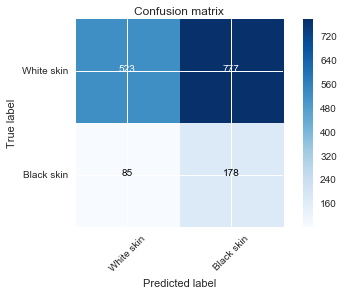

Silhouette score:  0.5227718172
Accuracy:  0.448496481126
F1 score:  0.292282430213


In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score

conf_mat = confusion_matrix(Y_true, Y_pred)
silhouette = silhouette_score(X_scaled, Y_pred)

custom_confusion_matrix(conf_mat, classes=['White skin', 'Black skin'],
                      title='Confusion matrix')

plt.show()
print("Silhouette score: ", silhouette)
print("Accuracy: ", (conf_mat[0,0] + conf_mat[1,1]) / (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]))
print("F1 score: ", f1_score(Y_true, Y_pred))

Let's try to drop features in order which seems to be the most resonable - where we believe two disjoint clusters are easy to find. 

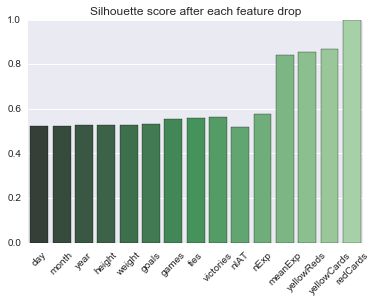

Confusion matrix, without normalization
[[  50 1250]
 [  29  234]]


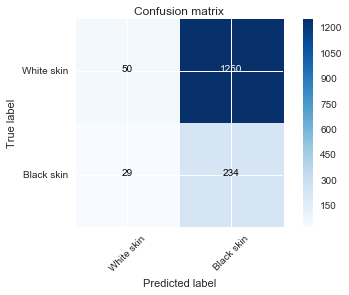

Accuracy:  0.181701855406
F1 score:  0.26788780767


In [63]:
X = X_copy
#Drop all features below = leave 'defeats' feature
to_drop = ['day', 'month', 'year', 'height', 'weight', 'goals', 'games', 'ties', 'victories', 'nIAT', 'nExp', 'meanExp', 'yellowReds', 'yellowCards', 'redCards']
silhouettes = []
for drop_column in to_drop:
    
    X = X.drop([drop_column], axis=1)
    X_scaled =  preprocessing.scale(X, axis=1)

    kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-2, init='k-means++').fit(X_scaled)
    Y_pred = kmeans.labels_

    conf_mat = confusion_matrix(Y_true, Y_pred)
    silhouette = silhouette_score(X_scaled, Y_pred)
    silhouettes.append(silhouette)
    
plt.title('Silhouette score after each feature drop')
silhouettes_plt = sns.barplot(x=to_drop, y=silhouettes, palette="Greens_d")
plt.setp(silhouettes_plt.get_xticklabels(), rotation=45)
plt.show()

plot_helpers.custom_confusion_matrix(conf_mat, classes=['White skin', 'Black skin'],
                      title='Confusion matrix')

plt.show()
print("Accuracy: ", (conf_mat[0,0] + conf_mat[1,1]) / (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]))
print("F1 score: ", f1_score(Y_true, Y_pred))

As we can see creating two distinct clusters with high silhouette score is not a problem if distincitve feature is selected and quite suprisingly it achieves high accuracy. However this is simply due to the fact that majority of the players are white. Moreover it is worth noting that F1 measure/score is very low which means that although two distinct clusters where achieved, they are not race based (whites and blacks are mixed in both clusters, not blacks in one and whites in other). 

In order to check if two distinct clusters for which players with dark and light skin colors belong to different clusters can be achieved, we brute forced calculations to find what is the best feature dropping order for which Silhouette score and F1 score is highest:
```
n_iters = 100
best_silhouette = 0.0
best_f1 = 0.0
best_drop_order = []
to_drop_list = []
Y_pred_best
for i in range(n_iters):
 
    to_drop = ['day', 'month', 'year', 'height', 'weight', 'goals', 'games','nIAT', 'nExp', 'meanExp','ties', 'yellowReds', 'yellowCards', 'redCards','defeats', 'victories',]
    np.random.shuffle(to_drop)
    to_drop = to_drop[:-1]
    X = X_copy
    
    print("Iteration: ", i)
    to_drop_list.append(to_drop)

    for drop_column in to_drop:
        X = X.drop([drop_column], axis=1)
        X_scaled =  preprocessing.scale(X, axis=1)
        kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-2, init='k-means++').fit(X_scaled)
        Y_pred = kmeans.labels_

        conf_mat = confusion_matrix(Y_true, Y_pred)
        accuracy = (conf_mat[0,0] + conf_mat[1,1]) / (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0])
        silhouette = silhouette_score(X_scaled, Y_pred)
        f1 = f1_score(Y_true, Y_pred)

        
        if ((silhouette > best_silhouette) and (f1 > best_f1)):
            best_silhouette = silhouette
            best_drop_order = to_drop
            best_f1 = f1
            
            print("Silhouette score: ", silhouette)
            print("Accuracy: ", accuracy)
            print("f1: ", f1)

```
in order to find out that:

In [64]:
best_drop_order = ['victories',
 'goals',
 'defeats',
 'redCards',
 'day',
 'month',
 'meanExp',
 'year',
 'yellowCards',
 'ties',
 'yellowReds',
 'height',
 'nExp',
 'nIAT',
 'weight']

Which means only one feature is left out:

In [65]:
to_drop = ['day', 'month','height', 'weight', 'goals','nIAT', 'nExp', 'meanExp','ties', 'yellowReds', 'yellowCards', 'defeats', 'year', 'games', 'victories', 'redCards']
left_feature = list(set(to_drop) - set(best_drop_order))
left_feature

['games']

Let's re-cluster for this best drop order and print some metrics.

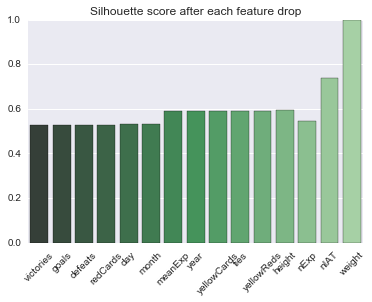

Confusion matrix, without normalization
[[1164  136]
 [ 203   60]]


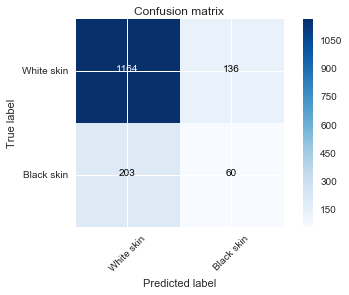

Accuracy:  0.78310940499
F1 score:  0.261437908497


In [66]:
X = X_copy
silhouettes = []
for drop_column in best_drop_order:
    X = X.drop([drop_column], axis=1)
    X_scaled =  preprocessing.scale(X, axis=1)
    kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-2, init='k-means++').fit(X_scaled)
    Y_pred = kmeans.labels_

    conf_mat = confusion_matrix(Y_true, Y_pred)
    silhouette = silhouette_score(X_scaled, Y_pred)
    silhouettes.append(silhouette)
    
plt.title('Silhouette score after each feature drop')
silhouettes_plt = sns.barplot(x=best_drop_order, y=silhouettes, palette="Greens_d")
plt.setp(silhouettes_plt.get_xticklabels(), rotation=45)
plt.show()

plot_helpers.custom_confusion_matrix(conf_mat, classes=['White skin', 'Black skin'],
                      title='Confusion matrix')

plt.show()
print("Accuracy: ", (conf_mat[0,0] + conf_mat[1,1]) / (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]))
print("F1 score: ", f1_score(Y_true, Y_pred))

Low F1 score speaks for itself.
This result upholds our previous thoughts and assumptions - there is no way of creating two distinct clusters where players with dark and light skin colors belong to different clusters. We can easily clusterize players such that silhouette score is high but this result is not skin color dependent. 

Ufff...! We are glad that when it comes to sports racism is not a thing! :)